# Imports

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration

In [203]:
class CFG:
    TRAIN_PATH = './Data/Current/train.csv'
    TEST_PATH = './Data/Current/test.csv'

    TRAIN_O_PATH = './Data/Original/Train.csv'
    TEST_O_PATH = './Data/Original/Test.csv'

    SUBMISSION_PATH = './Data/Current/sample_submission.csv'

    RANDOM_STATE = 59

    TARGET = 'BeatsPerMinute'


# Data Preprocessing

In [204]:
class DataPreprocessor:
    """
    Класс для предварительного анализа и подготовки наборов данных.
    Объединяет два тренировочных набора, выделяет целевую переменную,
    проводит анализ корреляции, мультиколлинеарности и выбросов.
    Предполагается, что целевая переменная - 'BeatsPerMinute'.
    """

    def __init__(self, train_path, test_path, train_o_path, target_column='BeatsPerMinute'):
        """
        Инициализация класса с путями к файлам данных.

        Args:
            train_path (str): Путь к первому тренировочному набору
            test_path (str): Путь к тестовому набору
            train_o_path (str): Путь ко второму тренировочному набору
            target_column (str): Название целевой переменной (по умолчанию 'BeatsPerMinute')
        """
        self.TRAIN_PATH = train_path
        self.TEST_PATH = test_path
        self.TRAIN_O_PATH = train_o_path
        self.TARGET_COLUMN = target_column  # Целевая переменная

        # Атрибуты для хранения датафреймов
        self.train_combined = None      # Полный объединённый тренировочный набор (с целевой)
        self.X_train = None             # Признаки (без целевой)
        self.y_train = None             # Целевая переменная
        self.test = None                # Тестовые данные (без целевой)
        
        self.target_column = target_column  # Для совместимости

    def load_and_combine_datasets(self):
        """
        Загружает и объединяет тренировочные наборы, выделяет целевую переменную.
        Тестовый набор загружается без изменений.
        """
        try:
            # Загрузка данных
            train1 = pd.read_csv(self.TRAIN_PATH, index_col='id')
            train2 = pd.read_csv(self.TRAIN_O_PATH)
            self.test = pd.read_csv(self.TEST_PATH, index_col='id')

            # Проверка совместимости столбцов между train1 и train2
            if not train1.columns.equals(train2.columns):
                print("❌ Столбцы в train1 и train2 не совпадают!")
                for col1, col2 in zip(train1.columns, train2.columns):
                    if col1 != col2:
                        print(f"  {col1} ≠ {col2}")
                raise ValueError("Столбцы в тренировочных наборах не совпадают!")

            # Объединение тренировочных наборов
            self.train_combined = pd.concat([train1, train2], ignore_index=False)  # Сохраняем id как индекс!
            print(f"✅ Объединённые тренировочные данные: {self.train_combined.shape}")

            # Разделение на признаки и цель
            if self.TARGET_COLUMN not in self.train_combined.columns:
                raise ValueError(f"Целевая переменная '{self.TARGET_COLUMN}' не найдена в тренировочных данных!")

            self.y_train = self.train_combined[self.TARGET_COLUMN]
            self.X_train = self.train_combined.drop(columns=[self.TARGET_COLUMN])

            # Убедимся, что в тесте нет целевой переменной
            if self.TARGET_COLUMN in self.test.columns:
                print(f"⚠️ Целевая переменная '{self.TARGET_COLUMN}' найдена в тесте — удаляется.")
                self.test = self.test.drop(columns=[self.TARGET_COLUMN])

            print(f"✅ Признаки (X_train): {self.X_train.shape}")
            print(f"✅ Целевая переменная (y_train): {self.y_train.shape}")
            print(f"✅ Тестовые данные (test): {self.test.shape}")

            return self.X_train, self.y_train, self.test

        except FileNotFoundError as e:
            print(f"❌ Файл не найден: {e}")
            return None, None, None
        except Exception as e:
            print(f"❌ Ошибка при загрузке или объединении данных: {e}")
            return None, None, None

    def optimize_dtypes(self, verbose=True):
        """
        Оптимизирует типы данных в X_train и test для снижения использования памяти.
        Применяется только к числовым столбцам.
        """
        if self.X_train is None or self.test is None:
            print("❌ Данные не загружены. Сначала вызовите load_and_combine_datasets().")
            return False

        def downcast_numeric(df):
            df_optimized = df.copy()
            for col in df_optimized.columns:
                if df_optimized[col].dtype != 'object':  # Только числовые столбцы
                    col_min = df_optimized[col].min()
                    col_max = df_optimized[col].max()

                    if df_optimized[col].dtype.kind == 'i':  # Целые числа
                        if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                            df_optimized[col] = df_optimized[col].astype(np.int8)
                        elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                            df_optimized[col] = df_optimized[col].astype(np.int16)
                        elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                            df_optimized[col] = df_optimized[col].astype(np.int32)
                        else:
                            df_optimized[col] = df_optimized[col].astype(np.int64)

                    elif df_optimized[col].dtype.kind == 'f':  # Вещественные числа
                        if col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                            df_optimized[col] = df_optimized[col].astype(np.float32)
                        else:
                            df_optimized[col] = df_optimized[col].astype(np.float64)
            return df_optimized

        # Оптимизация признаков и теста
        self.X_train = downcast_numeric(self.X_train)
        self.test = downcast_numeric(self.test)

        if verbose:
            mem_before = self.X_train.memory_usage(deep=True).sum() / 1e6
            mem_after = self.X_train.memory_usage(deep=True).sum() / 1e6
            print(f"✅ Оптимизация типов данных завершена.")
            print(f"   Память X_train: {mem_before:.2f} MB → {mem_after:.2f} MB")
            print(f"   Память test: {self.test.memory_usage(deep=True).sum() / 1e6:.2f} MB")

        return True

    def analyze_correlation(self, threshold=0.8, plot=True):
        """
        Анализирует корреляцию между признаками (без целевой переменной).
        Выявляет высоко коррелирующие пары (по порогу).
        """
        if self.X_train is None:
            print("❌ Данные не загружены. Сначала вызовите load_and_combine_datasets().")
            return []

        numeric_cols = self.X_train.select_dtypes(include=[np.number]).columns
        corr_matrix = self.X_train[numeric_cols].corr()

        if plot:
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=.5)
            plt.title('Матрица корреляции признаков (без целевой переменной)')
            plt.show()

        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    high_corr_pairs.append((corr_matrix.index[i],
                                           corr_matrix.columns[j],
                                           corr_matrix.iloc[i, j]))

        if high_corr_pairs:
            print(f"\n🔍 Найдено {len(high_corr_pairs)} пар признаков с корреляцией выше {threshold}:")
            for pair in high_corr_pairs:
                print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.4f}")
        else:
            print(f"\n✅ Высоких корреляций (выше {threshold}) не обнаружено.")

        return high_corr_pairs

    def detect_multicollinearity(self, threshold_vif=5.0):
        """
        Проверяет наличие мультиколлинеарности между признаками через VIF.
        """
        if self.X_train is None:
            print("❌ Данные не загружены. Сначала вызовите load_and_combine_datasets().")
            return {}

        # Подготовка данных: заполнение NaN средним
        df_for_vif = self.X_train.select_dtypes(include=[np.number]).fillna(self.X_train.mean())

        # Расчёт VIF
        vif_data = pd.DataFrame()
        vif_data["feature"] = df_for_vif.columns
        vif_data["VIF"] = [variance_inflation_factor(df_for_vif.values, i)
                          for i in range(df_for_vif.shape[1])]

        print("\n📊 Variance Inflation Factor (VIF):")
        print(vif_data.sort_values('VIF', ascending=False).round(4))

        high_vif = vif_data[vif_data['VIF'] > threshold_vif]
        if len(high_vif) > 0:
            print(f"\n⚠️ Признаки с потенциальной мультиколлинеарностью (VIF > {threshold_vif}):")
            print(high_vif)
        else:
            print(f"\n✅ Мультиколлинеарность отсутствует (все VIF ≤ {threshold_vif}).")

        return vif_data.set_index('feature')['VIF'].to_dict()

    def detect_outliers(self, method='iqr', plot=True):
        """
        Выявляет выбросы в признаках (без целевой переменной) с помощью IQR или Z-score.
        """
        if self.X_train is None:
            print("❌ Данные не загружены. Сначала вызовите load_and_combine_datasets().")
            return {}

        numeric_cols = self.X_train.select_dtypes(include=[np.number]).columns
        outliers_count = {}

        for col in numeric_cols:
            if method == 'iqr':
                Q1 = self.X_train[col].quantile(0.25)
                Q3 = self.X_train[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = self.X_train[(self.X_train[col] < lower_bound) | (self.X_train[col] > upper_bound)]
                outliers_count[col] = len(outliers)

            elif method == 'zscore':
                z_scores = np.abs((self.X_train[col] - self.X_train[col].mean()) / self.X_train[col].std())
                outliers = self.X_train[z_scores > 3]
                outliers_count[col] = len(outliers)

            else:
                raise ValueError("Метод должен быть 'iqr' или 'zscore'")

        print(f"\n📉 Количество выбросов по признакам ({method.upper()} метод):")
        for col, count in sorted(outliers_count.items(), key=lambda x: x[1], reverse=True):
            if count > 0:
                print(f"  {col}: {count}")

        if plot and len(numeric_cols) > 0:
            n_plots = len(numeric_cols)
            n_rows = (n_plots // 3) + 1
            fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
            axes = axes.flatten() if n_plots > 1 else [axes]

            for i, col in enumerate(numeric_cols):
                self.X_train.boxplot(column=col, ax=axes[i])
                axes[i].set_title(col)

            # Удаляем лишние подграфики
            for i in range(n_plots, len(axes)):
                fig.delaxes(axes[i])

            plt.tight_layout()
            plt.show()

        return outliers_count

✅ Объединённые тренировочные данные: (538797, 10)
✅ Признаки (X_train): (538797, 9)
✅ Целевая переменная (y_train): (538797,)
✅ Тестовые данные (test): (174722, 9)
✅ Оптимизация типов данных завершена.
   Память X_train: 23.71 MB → 23.71 MB
   Память test: 7.69 MB


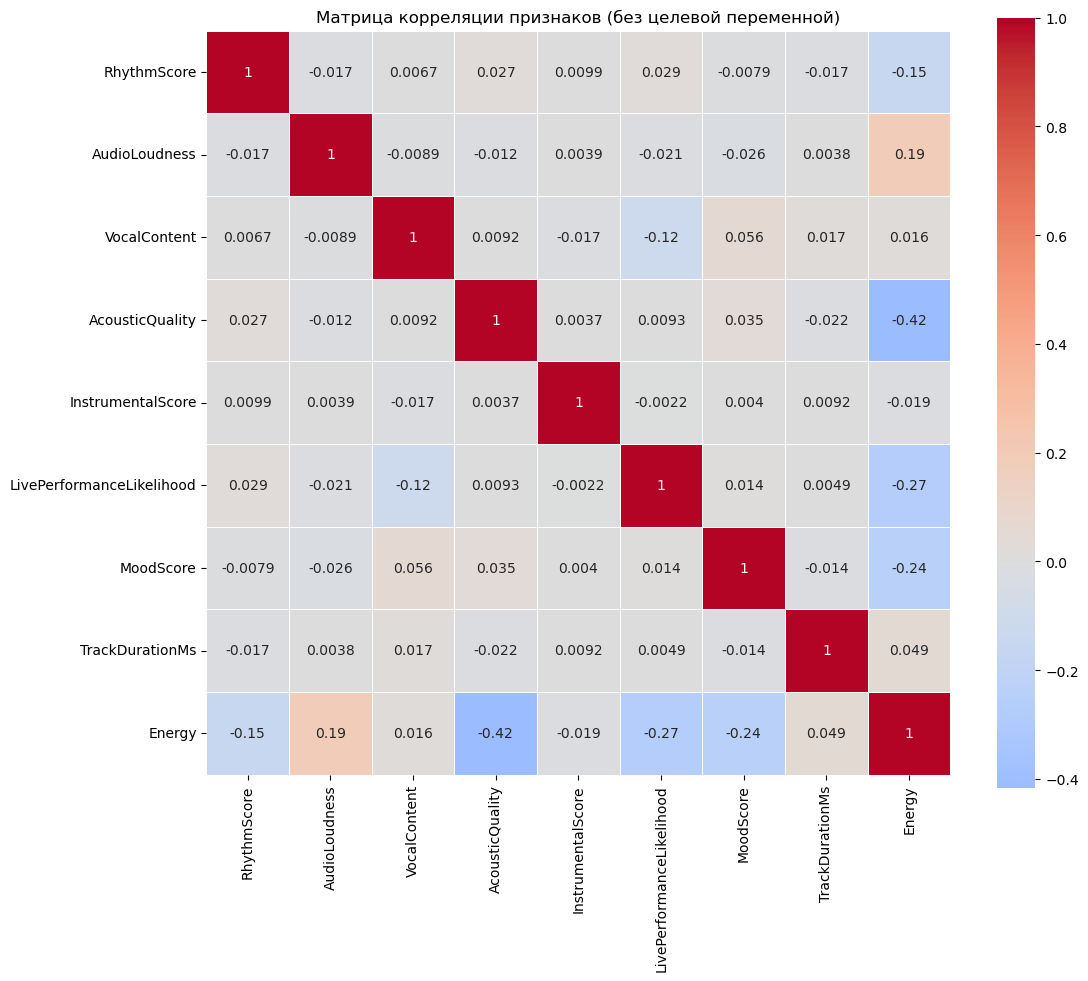


✅ Высоких корреляций (выше 0.8) не обнаружено.

📊 Variance Inflation Factor (VIF):
                     feature      VIF
7            TrackDurationMs  13.7096
0                RhythmScore  12.1713
6                  MoodScore   6.2777
8                     Energy   4.1706
1              AudioLoudness   4.0691
5  LivePerformanceLikelihood   3.2446
2               VocalContent   3.1838
3            AcousticQuality   2.5978
4          InstrumentalScore   1.7738

⚠️ Признаки с потенциальной мультиколлинеарностью (VIF > 5.0):
           feature        VIF
0      RhythmScore  12.171336
6        MoodScore   6.277694
7  TrackDurationMs  13.709613

📉 Количество выбросов по признакам (IQR метод):
  AcousticQuality: 6947
  TrackDurationMs: 4639
  InstrumentalScore: 3227
  AudioLoudness: 1787
  VocalContent: 1231
  LivePerformanceLikelihood: 248
  RhythmScore: 155


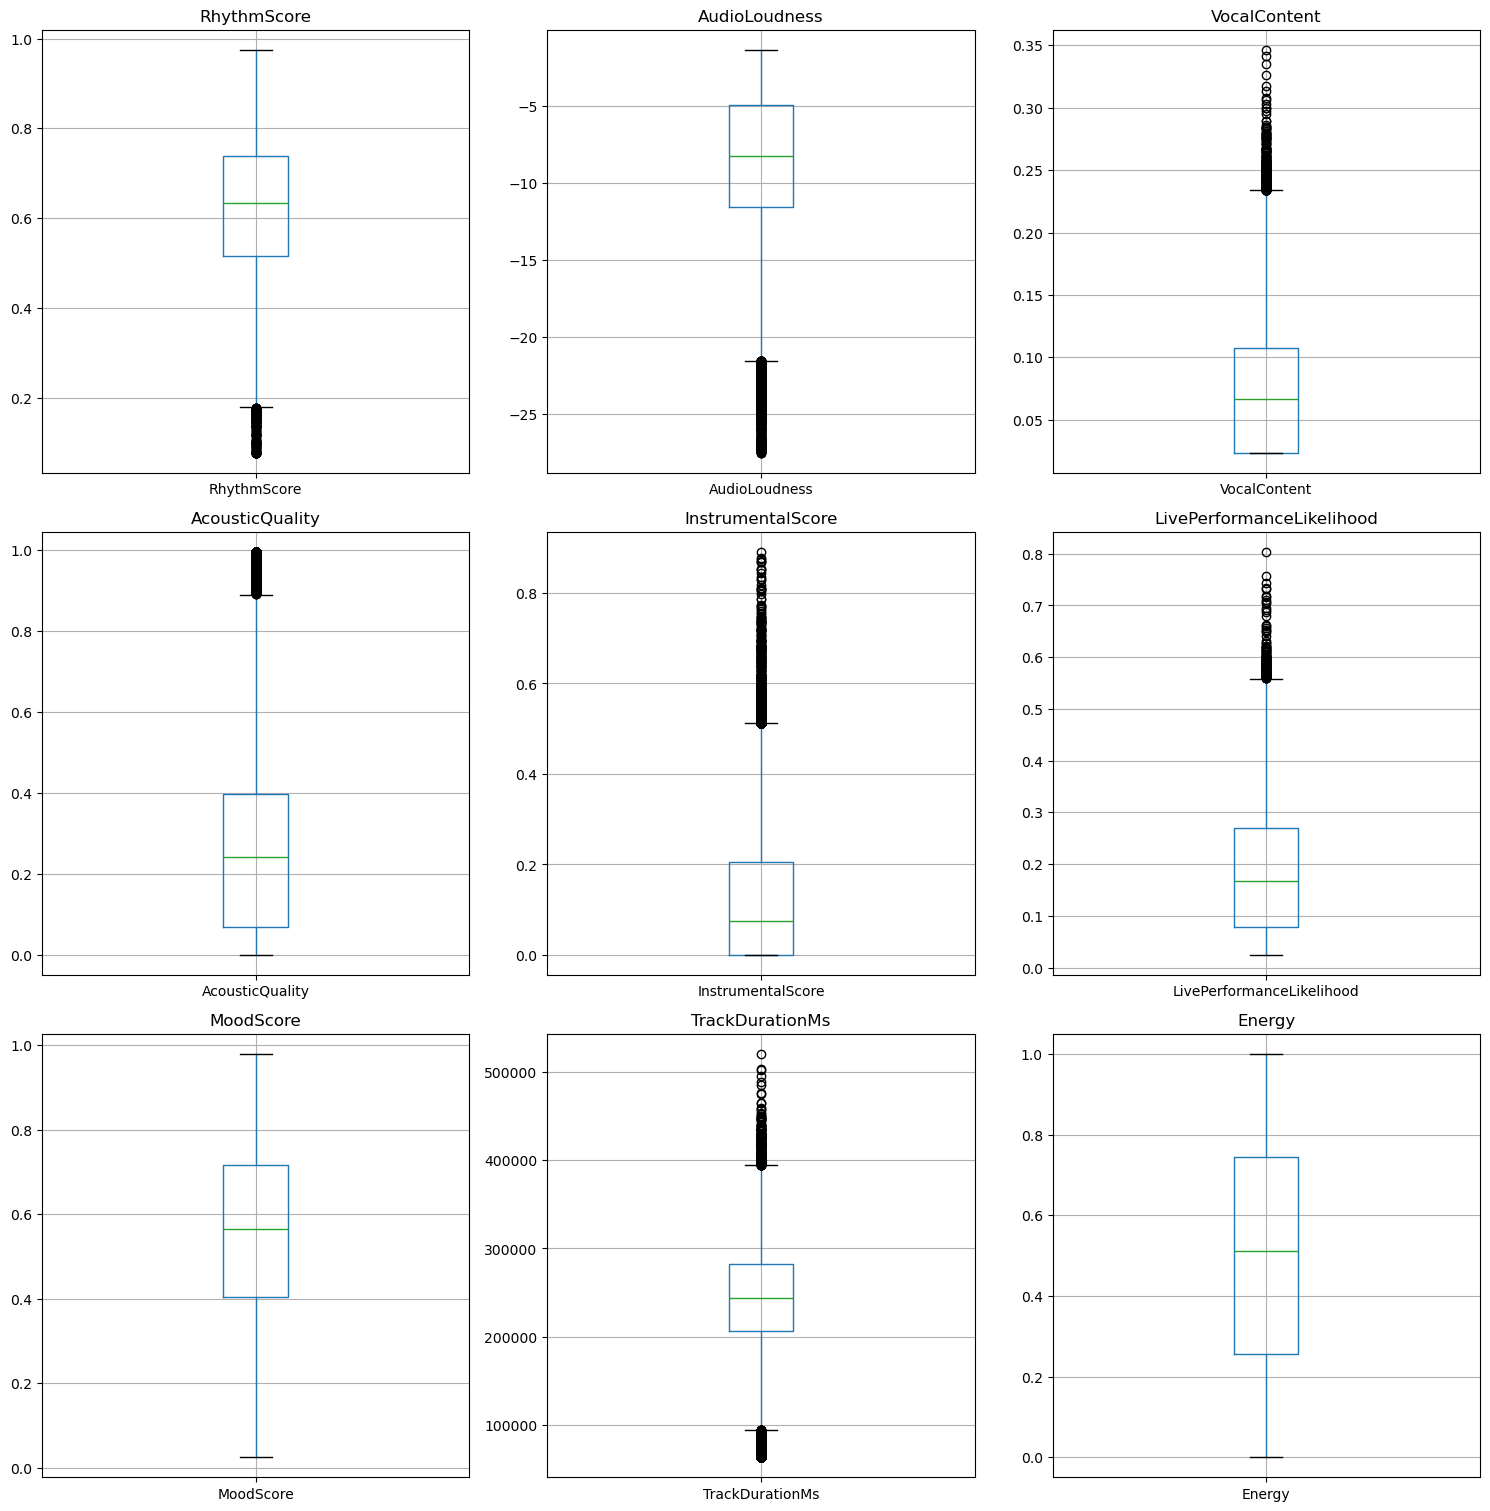

In [205]:
# Создание экземпляра класса
preprocessor = DataPreprocessor(
    CFG.TRAIN_PATH,
    CFG.TEST_PATH,
    CFG.TRAIN_O_PATH,
    target_column=CFG.TARGET
    )

# Загрузка и объединение данных
X_train, y_train, test = preprocessor.load_and_combine_datasets()

# Оптимизация типов данных для экономии памяти
preprocessor.optimize_dtypes()

# Анализ корреляции между признаками
high_corr_pairs = preprocessor.analyze_correlation(threshold=0.8)

# Проверка мультиколлинеарности (вздутие дисперсии)
vif_results = preprocessor.detect_multicollinearity(threshold_vif=5.0)

# Обнаружение выбросов методом IQR
outliers = preprocessor.detect_outliers(method='iqr')

In [206]:
# --- ПРЕОБРАЗОВАНИЯ ПОСЛЕ load_and_combine_datasets() ---

# 1. Удаление проблемных признаков
X_train = X_train.drop(columns=['TrackDurationMs', 'MoodScore'])
test = test.drop(columns=['TrackDurationMs', 'MoodScore'])

# 2. Создание EstimatedTotalBeats
X_train['EstimatedTotalBeats'] = (
    X_train['RhythmScore'] * 
    X_train['Energy'] * 
    (1 + X_train['InstrumentalScore']) / 
    (1 + X_train['VocalContent'] + 1e-8)
)
test['EstimatedTotalBeats'] = (
    test['RhythmScore'] * 
    test['Energy'] * 
    (1 + test['InstrumentalScore']) / 
    (1 + test['VocalContent'] + 1e-8)
)


X_train['VocalToInstRatio'] = X_train['VocalContent'] / (X_train['InstrumentalScore'] + 1e-8)
test['VocalToInstRatio'] = test['VocalContent'] / (test['InstrumentalScore'] + 1e-8)

# 3. Удаление исходных признаков, вошедших в EstimatedTotalBeats
X_train = X_train.drop(columns=['RhythmScore', 'Energy', 'InstrumentalScore', 'VocalContent'])
test = test.drop(columns=['RhythmScore', 'Energy', 'InstrumentalScore', 'VocalContent'])

# 4. Преобразование AcousticQuality
min_nonzero = X_train['AcousticQuality'][X_train['AcousticQuality'] > 0].min()
X_train['AcousticQuality'] = X_train['AcousticQuality'].replace(0, min_nonzero)
test['AcousticQuality'] = test['AcousticQuality'].replace(0, min_nonzero)
X_train['AcousticQuality'] = np.log1p(X_train['AcousticQuality'])
test['AcousticQuality'] = np.log1p(test['AcousticQuality'])

# 5. Каппинг AudioLoudness
X_train['AudioLoudness'] = X_train['AudioLoudness'].clip(lower=-30, upper=0)
test['AudioLoudness'] = test['AudioLoudness'].clip(lower=-30, upper=0)

# 6. Создание новых признаков
median_duration_sec = 240  # ~4 минуты
X_train['RhythmDensity'] = X_train['EstimatedTotalBeats'] / median_duration_sec
test['RhythmDensity'] = test['EstimatedTotalBeats'] / median_duration_sec


# 7. Логарифмирование некоторых признаков
log_cols = ['AudioLoudness', 'LivePerformanceLikelihood', 'EstimatedTotalBeats']
for col in log_cols:
    if col in X_train.columns:
        X_train[f'{col}_log'] = np.log1p(X_train[col])
        test[f'{col}_log'] = np.log1p(test[col])

In [207]:
# --- ШАГ 1: Выберите только числовые признаки ---
df_vif = X_train.select_dtypes(include=[np.number]).copy()

# --- ШАГ 2: Удалите столбцы, где все значения NaN ---
df_vif = df_vif.dropna(axis=1, how='all')

# --- ШАГ 3: Замените inf и -inf на NaN ---
df_vif.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- ШАГ 4: Заполните NaN медианой (наиболее устойчивый способ) ---
for col in df_vif.columns:
    median_val = df_vif[col].median()
    if pd.isna(median_val):  # Если и медиана NaN — заполнить нулём
        median_val = 0
    df_vif[col].fillna(median_val, inplace=True)

# --- ШАГ 5: Проверим, что всё чисто ---
print("✅ Проверка на NaN и inf:")
print(f"Количество NaN: {df_vif.isna().sum().sum()}")
print(f"Количество inf: {(np.isinf(df_vif)).sum().sum()}")

if df_vif.isna().sum().sum() > 0 or (np.isinf(df_vif)).sum().sum() > 0:
    print("❌ Ошибка: остались NaN/inf!")
else:
    print("✅ Данные готовы к расчёту VIF.")

# --- ШАГ 6: Расчёт VIF ---
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_vif.values, i) 
    for i in range(df_vif.shape[1])
]

print("\n📊 VIF после всех преобразований:")
print(vif_data.sort_values('VIF', ascending=False).round(3))

✅ Проверка на NaN и inf:
Количество NaN: 0
Количество inf: 0
✅ Данные готовы к расчёту VIF.

📊 VIF после всех преобразований:
                         feature       VIF
3            EstimatedTotalBeats       inf
5                  RhythmDensity       inf
6  LivePerformanceLikelihood_log  1129.033
2      LivePerformanceLikelihood  1055.977
7        EstimatedTotalBeats_log   314.848
0                  AudioLoudness     3.475
1                AcousticQuality     2.362
4               VocalToInstRatio     1.295


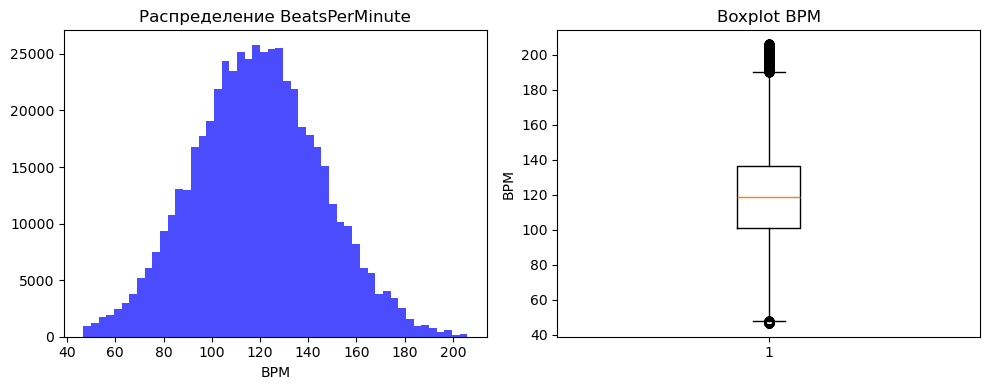

In [208]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50, color='blue', alpha=0.7)
plt.title('Распределение BeatsPerMinute')
plt.xlabel('BPM')

plt.subplot(1, 2, 2)
plt.boxplot(y_train)
plt.title('Boxplot BPM')
plt.ylabel('BPM')

plt.tight_layout()
plt.show()

# CatBoost

In [209]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=CFG.RANDOM_STATE, shuffle=True
)

In [210]:
class CatBoostOptimizer:
    """
    Композиция для обучения CatBoostRegressor с автоматическим подбором гиперпараметров через Optuna.
    Использует RMSE как целевую метрику оптимизации.
    """
    
    def __init__(self, X_train, y_train, X_val, y_val, random_state=CFG.RANDOM_STATE):
        """
        Инициализация оптимизатора.
        
        Args:
            X_train (pd.DataFrame): Обучающие признаки
            y_train (pd.Series): Целевая переменная для обучения
            X_val (pd.DataFrame): Валидационные признаки
            y_val (pd.Series): Целевая переменная для валидации
            random_state (int): Фиксированный seed для воспроизводимости
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.random_state = random_state
        self.best_model = None
        self.best_params = None
        self.best_rmse = float('inf')
        
        # Определяем категориальные признаки (если есть)
        self.cat_features = self._detect_categorical_features()
        
    def _detect_categorical_features(self):
        """
        Автоматическое определение категориальных признаков (object или bool).
        """
        cat_features = []
        for col in self.X_train.columns:
            if self.X_train[col].dtype == 'object' or self.X_train[col].dtype.name == 'category':
                cat_features.append(col)
            elif self.X_train[col].dtype == 'bool':
                cat_features.append(col)
        return cat_features
    
    def objective(self, trial):
        """
        Целевая функция для Optuna — минимизация RMSE на валидационной выборке.
        """
        # Гиперпараметры для подбора
        params = {
            'iterations': trial.suggest_int('iterations', 5000, 12000, step=500),
            'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.1, log=True),
            'depth': trial.suggest_int('depth', 6, 11),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': False,
            'random_seed': self.random_state,
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'task_type': 'GPU',  # Для ускорения можно использовать 'GPU'
            'use_best_model': True,
            'early_stopping_rounds': 100
        }
        
        # Создание и обучение модели
        model = CatBoostRegressor(**params)
        model.fit(
            self.X_train, 
            self.y_train,
            cat_features=self.cat_features,
            eval_set=(self.X_val, self.y_val),
            verbose=False,
        )
        
        # Прогноз на валидации
        y_pred = model.predict(self.X_val)
        
        # Расчет RMSE
        rmse = np.sqrt(mean_squared_error(self.y_val, y_pred))
        
        return rmse
    
    def _get_model_from_trial(self, trial):
        """Восстанавливает модель из конкретного трала Optuna"""
        params = {
            'iterations': trial.params['iterations'],
            'learning_rate': trial.params['learning_rate'],
            'depth': trial.params['depth'],
            'l2_leaf_reg': trial.params['l2_leaf_reg'],
            'bagging_temperature': trial.params['bagging_temperature'],
            'random_strength': trial.params['random_strength'],
            'border_count': trial.params['border_count'],
            'verbose': False,
            'random_seed': self.random_state,
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'task_type': 'GPU',
            'use_best_model': True,
            'early_stopping_rounds': 100,
        }

        model = CatBoostRegressor(**params)
        model.fit(
            self.X_train,
            self.y_train,
            cat_features=self.cat_features,
            eval_set=(self.X_val, self.y_val),
            verbose=False,
        )
        return model

    
    def optimize(self, n_trials=50, timeout=None, show_progress=True):
        """
        Запуск оптимизации параметров с помощью Optuna.
        
        Args:
            n_trials (int): Количество испытаний
            timeout (int): Максимальное время выполнения в секундах (None — без ограничения)
            show_progress (bool): Отображать прогресс
        """
        print("Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...")
        
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=self.random_state))
        
        study.optimize(
            self.objective, 
            n_trials=n_trials, 
            timeout=timeout,
            show_progress_bar=show_progress
        )
        
        # После study.optimize()
        best_trial = study.best_trial
        self.best_params = best_trial.params
        self.best_rmse = best_trial.value

        # Сохраняем модель из лучшего трала
        self.best_model = self._get_model_from_trial(best_trial)
        
        print(f"\n✅ Лучшие параметры:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"  RMSE: {self.best_rmse:.6f}")
        
        # Обучение финальной модели на всех данных (обучение + валидация)
        self.final_model = self.best_model
        
        return study
    
    
    def train_final_model(self):
        """
        Обучает финальную модель на объединённых обучающих и валидационных данных
        с лучшими найденными параметрами.
        """
        X_combined = pd.concat([self.X_train, self.X_val], axis=0)
        y_combined = pd.concat([self.y_train, self.y_val], axis=0)
        
        # Убираем параметры, требующие eval_set, так как мы обучаемся на всех данных
        final_params = self.best_params.copy()
        final_params.update({
            'verbose': False,
            'random_seed': self.random_state,
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'task_type': 'GPU',
        })
        # Удаляем параметры, которые требуют eval_set
        final_params.pop('use_best_model', None)
        final_params.pop('early_stopping_rounds', None)

        self.best_model = CatBoostRegressor(**final_params)
        self.best_model.fit(
            X_combined, 
            y_combined,
            cat_features=self.cat_features,
            verbose=False
        )
        
        print("✅ Финальная модель обучена на объединённых данных.")
    
    def predict(self, X_test):
        """
        Делает предсказания на новых данных.
        
        Args:
            X_test (pd.DataFrame): Тестовые данные
            
        Returns:
            np.array: Предсказанные значения
        """
        if self.best_model is None:
            raise ValueError("Модель не обучена. Сначала запустите optimize().")
        
        return self.best_model.predict(X_test)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков.
        """
        if self.best_model is None:
            raise ValueError("Модель не обучена. Сначала запустите optimize().")
        
        importance = pd.DataFrame({
            'feature': self.best_model.feature_names_,
            'importance': self.best_model.get_feature_importance()
        }).sort_values('importance', ascending=False)
        
        return importance

In [211]:
from sklearn.model_selection import KFold
import numpy as np

# Настройка K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=CFG.RANDOM_STATE)

oof_predictions = np.zeros(len(X_train))  # out-of-fold predictions
test_predictions = np.zeros(len(test))    # для агрегации предсказаний по тесту
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n🔄 Фолд {fold+1}/5")
    
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    optimizer = CatBoostOptimizer(
        X_train=X_fold_train,
        y_train=y_fold_train,
        X_val=X_fold_val,
        y_val=y_fold_val,
        random_state=CFG.RANDOM_STATE
    )
    
    study = optimizer.optimize(n_trials=300, timeout=300, show_progress=False)
    
    # Сохраняем модель
    models.append(optimizer.best_model)
    
    # Предсказание на валидации
    oof_predictions[val_idx] = optimizer.best_model.predict(X_fold_val)
    
    # Предсказание на тесте (накапливаем)
    test_predictions += optimizer.best_model.predict(test) / 5  # усредняем

# Оценка OOF RMSE (реальная оценка модели)
oof_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
print(f"\n✅ OOF RMSE (средняя по фолдам): {oof_rmse:.6f}")

[I 2025-09-14 01:04:41,848] A new study created in memory with name: no-name-a2276e72-5177-44de-bf85-632af6b3e1ba



🔄 Фолд 1/5
Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...


[I 2025-09-14 01:04:46,124] Trial 0 finished with value: 26.448832266498716 and parameters: {'iterations': 11500, 'learning_rate': 0.0011540774243055934, 'depth': 11, 'l2_leaf_reg': 0.0021708397407460733, 'bagging_temperature': 5.735736839376276, 'random_strength': 2.8193976686291276, 'border_count': 89}. Best is trial 0 with value: 26.448832266498716.
[I 2025-09-14 01:04:49,584] Trial 1 finished with value: 26.44845001808319 and parameters: {'iterations': 9000, 'learning_rate': 0.0016024708221716777, 'depth': 9, 'l2_leaf_reg': 0.3243463161202473, 'bagging_temperature': 4.109744103613022, 'random_strength': 4.025433578653451, 'border_count': 132}. Best is trial 1 with value: 26.44845001808319.
[I 2025-09-14 01:04:54,452] Trial 2 finished with value: 26.447876411453542 and parameters: {'iterations': 6500, 'learning_rate': 0.0010187585518715604, 'depth': 6, 'l2_leaf_reg': 0.07797599348305913, 'bagging_temperature': 1.1384753583850238, 'random_strength': 2.8604698669753947, 'border_count'


✅ Лучшие параметры:
  iterations: 12000
  learning_rate: 0.0717145797855961
  depth: 7
  l2_leaf_reg: 1.7719744250804537
  bagging_temperature: 1.9646336458371736
  random_strength: 7.356198771269283
  border_count: 218
  RMSE: 26.447277

🔄 Фолд 2/5
Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...


[I 2025-09-14 01:09:52,871] Trial 0 finished with value: 26.451632176712167 and parameters: {'iterations': 11500, 'learning_rate': 0.0011540774243055934, 'depth': 11, 'l2_leaf_reg': 0.0021708397407460733, 'bagging_temperature': 5.735736839376276, 'random_strength': 2.8193976686291276, 'border_count': 89}. Best is trial 0 with value: 26.451632176712167.
[I 2025-09-14 01:09:58,276] Trial 1 finished with value: 26.451322433651274 and parameters: {'iterations': 9000, 'learning_rate': 0.0016024708221716777, 'depth': 9, 'l2_leaf_reg': 0.3243463161202473, 'bagging_temperature': 4.109744103613022, 'random_strength': 4.025433578653451, 'border_count': 132}. Best is trial 1 with value: 26.451322433651274.
[I 2025-09-14 01:10:03,707] Trial 2 finished with value: 26.45139835759372 and parameters: {'iterations': 6500, 'learning_rate': 0.0010187585518715604, 'depth': 6, 'l2_leaf_reg': 0.07797599348305913, 'bagging_temperature': 1.1384753583850238, 'random_strength': 2.8604698669753947, 'border_count


✅ Лучшие параметры:
  iterations: 8000
  learning_rate: 0.08680902593828034
  depth: 7
  l2_leaf_reg: 0.013620954073328617
  bagging_temperature: 4.879711469519433
  random_strength: 5.638510989209705
  border_count: 48
  RMSE: 26.450250

🔄 Фолд 3/5
Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...


[I 2025-09-14 01:14:52,173] Trial 0 finished with value: 26.421344080681774 and parameters: {'iterations': 11500, 'learning_rate': 0.0011540774243055934, 'depth': 11, 'l2_leaf_reg': 0.0021708397407460733, 'bagging_temperature': 5.735736839376276, 'random_strength': 2.8193976686291276, 'border_count': 89}. Best is trial 0 with value: 26.421344080681774.
[I 2025-09-14 01:14:55,710] Trial 1 finished with value: 26.420964780868484 and parameters: {'iterations': 9000, 'learning_rate': 0.0016024708221716777, 'depth': 9, 'l2_leaf_reg': 0.3243463161202473, 'bagging_temperature': 4.109744103613022, 'random_strength': 4.025433578653451, 'border_count': 132}. Best is trial 1 with value: 26.420964780868484.
[I 2025-09-14 01:15:00,325] Trial 2 finished with value: 26.420343399404832 and parameters: {'iterations': 6500, 'learning_rate': 0.0010187585518715604, 'depth': 6, 'l2_leaf_reg': 0.07797599348305913, 'bagging_temperature': 1.1384753583850238, 'random_strength': 2.8604698669753947, 'border_coun


✅ Лучшие параметры:
  iterations: 7000
  learning_rate: 0.033938675754653924
  depth: 7
  l2_leaf_reg: 1.5979626998509133
  bagging_temperature: 2.4171947357692765
  random_strength: 3.201637594475923
  border_count: 218
  RMSE: 26.419167

🔄 Фолд 4/5
Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...


[I 2025-09-14 01:19:56,967] Trial 0 finished with value: 26.50290354740036 and parameters: {'iterations': 11500, 'learning_rate': 0.0011540774243055934, 'depth': 11, 'l2_leaf_reg': 0.0021708397407460733, 'bagging_temperature': 5.735736839376276, 'random_strength': 2.8193976686291276, 'border_count': 89}. Best is trial 0 with value: 26.50290354740036.
[I 2025-09-14 01:20:06,625] Trial 1 finished with value: 26.502333103028576 and parameters: {'iterations': 9000, 'learning_rate': 0.0016024708221716777, 'depth': 9, 'l2_leaf_reg': 0.3243463161202473, 'bagging_temperature': 4.109744103613022, 'random_strength': 4.025433578653451, 'border_count': 132}. Best is trial 1 with value: 26.502333103028576.
[I 2025-09-14 01:20:18,880] Trial 2 finished with value: 26.502586394271034 and parameters: {'iterations': 6500, 'learning_rate': 0.0010187585518715604, 'depth': 6, 'l2_leaf_reg': 0.07797599348305913, 'bagging_temperature': 1.1384753583850238, 'random_strength': 2.8604698669753947, 'border_count'


✅ Лучшие параметры:
  iterations: 6000
  learning_rate: 0.038505639148505036
  depth: 10
  l2_leaf_reg: 0.2379464031251476
  bagging_temperature: 2.510225132407253
  random_strength: 4.453001978341245
  border_count: 146
  RMSE: 26.500938

🔄 Фолд 5/5
Запуск оптимизации гиперпараметров CatBoostRegressor через Optuna...


[I 2025-09-14 01:24:52,249] Trial 0 finished with value: 26.49875998396005 and parameters: {'iterations': 11500, 'learning_rate': 0.0011540774243055934, 'depth': 11, 'l2_leaf_reg': 0.0021708397407460733, 'bagging_temperature': 5.735736839376276, 'random_strength': 2.8193976686291276, 'border_count': 89}. Best is trial 0 with value: 26.49875998396005.
[I 2025-09-14 01:24:53,238] Trial 1 finished with value: 26.498749398564154 and parameters: {'iterations': 9000, 'learning_rate': 0.0016024708221716777, 'depth': 9, 'l2_leaf_reg': 0.3243463161202473, 'bagging_temperature': 4.109744103613022, 'random_strength': 4.025433578653451, 'border_count': 132}. Best is trial 1 with value: 26.498749398564154.
[I 2025-09-14 01:24:53,882] Trial 2 finished with value: 26.49877445406763 and parameters: {'iterations': 6500, 'learning_rate': 0.0010187585518715604, 'depth': 6, 'l2_leaf_reg': 0.07797599348305913, 'bagging_temperature': 1.1384753583850238, 'random_strength': 2.8604698669753947, 'border_count':


✅ Лучшие параметры:
  iterations: 8000
  learning_rate: 0.06522198021447641
  depth: 10
  l2_leaf_reg: 0.016558754083845176
  bagging_temperature: 5.365252386415008
  random_strength: 7.150489905402646
  border_count: 109
  RMSE: 26.498196

✅ OOF RMSE (средняя по фолдам): 26.463184


In [216]:
# Делаем предсказания
predictions = optimizer.predict(test)

print("\n" + "="*60)
print("✅ ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ (первые 10):")
print(predictions[:10])


# --- ВАЖНОСТЬ ПРИЗНАКОВ ---
feature_importance = optimizer.get_feature_importance()
print("\n" + "="*60)
print("🔝 ТОП-10 ВАЖНЫХ ПРИЗНАКОВ:")
print(feature_importance.head(10))


✅ ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ (первые 10):
[119.26253709 119.042857   119.13067073 119.06932361 119.10502726
 119.14935364 119.18689592 119.08597128 118.96583959 119.07296823]

🔝 ТОП-10 ВАЖНЫХ ПРИЗНАКОВ:
                         feature  importance
7  LivePerformanceLikelihood_log   22.426005
0                  AudioLoudness   20.123601
1                AcousticQuality   19.756108
4               VocalToInstRatio   18.549666
8        EstimatedTotalBeats_log    7.421422
5                  RhythmDensity    6.295832
3            EstimatedTotalBeats    5.427366
2      LivePerformanceLikelihood    0.000000
6              AudioLoudness_log    0.000000


In [217]:
submission = pd.read_csv(CFG.SUBMISSION_PATH)

In [220]:
submission = submission[['id']]
submission['Response'] = test_predictions * 0.9995

submission.to_csv('submission.csv', index=False)
submission

,id,Response
0,524164,119.283828
1,524165,119.062550
2,524166,119.189660
3,524167,119.085066
4,524168,118.767547
...,...,...
174717,698881,119.127235
174718,698882,119.249485
174719,698883,119.115853
174720,698884,119.059633
